🔧 MAP Delensing Quick Fix v2
Loading data...
✓ Data shape: (512, 512)
✓ Using resolution parameters: LD_res=HD_res=9 (for 512×512)
Preprocessing data...
After preprocessing - I range:[-378.51,349.83], RMS:92.96
Setting up libraries and configuration...
Ellmax limits: data[10-1500], sky[0-2000], reconstruction[0-1500]
✓ Libraries created successfully
  Data ellmax: 56-1498
  Sky ellmax: 0-1998
  Reconstruction ellmax: 0-1498
Converting data to ALM space...
✓ ALM conversion successful, shape: (3, 1130)
Setting up covariance...
Calculating initial estimate (using only QU polarization data)...
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
✓ Initial estimate successful, range: [0.00e+00, 5.00e-06]
Setting up iterator...
 I see t 70.0
 I see q 98.99494936611666
 I see u 98.99494936611666
ffs iterator : This is 0 trying to setup /

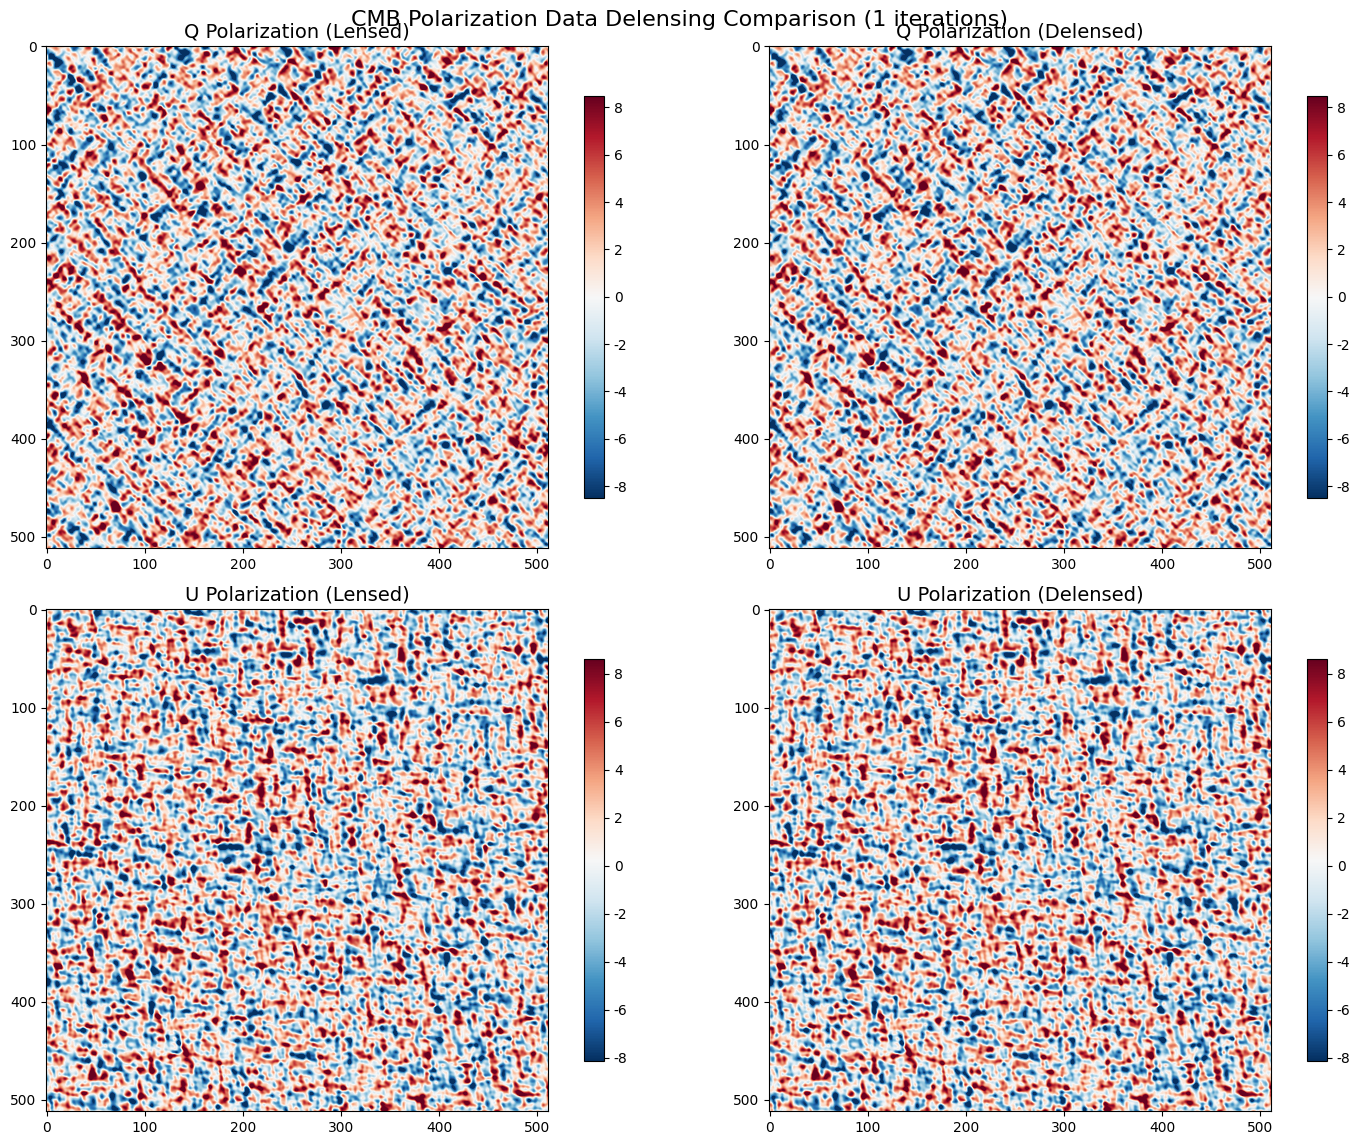

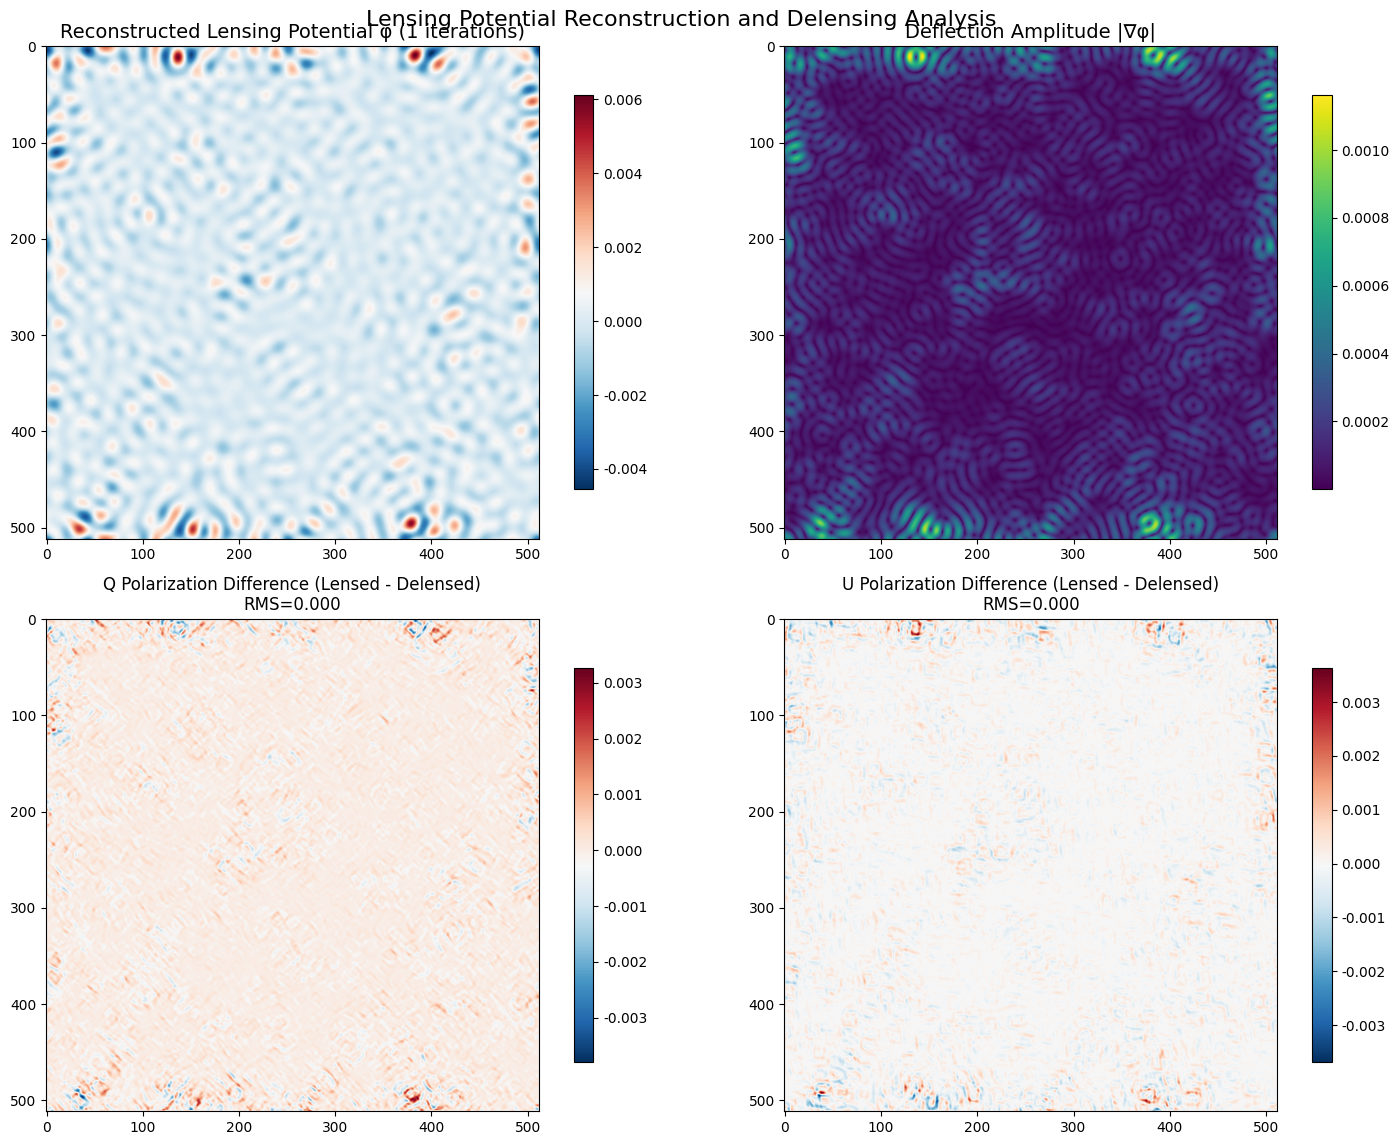


🎉 Quick Fix v2 processing completed successfully!
Successfully completed 1 MAP iterations (max 5)
Output files:
- results/quick_fix_v2_comparison.png: Lensed vs Delensed comparison plot
- results/quick_fix_v2_analysis.png: Lensing potential reconstruction and difference analysis
- results/: I, Q, U lensed and delensed numerical results
  • I_lensed.npy, Q_lensed.npy, U_lensed.npy
  • I_delensed.npy, Q_delensed.npy, U_delensed.npy
  • reconstructed_phi.npy, reconstructed_plm.npy


In [3]:
#!/usr/bin/env python3
"""
MAP Delensing 
author: nisl
"""

import numpy as np
import os
import matplotlib.pyplot as plt
import lensit as li
from lensit.ffs_iterators.ffs_iterator import ffs_iterator_pertMF
from lensit.misc.misc_utils import gauss_beam
from lensit.qcinv import ffs_ninv_filt_ideal, chain_samples
from lensit.ffs_covs import ell_mat, ffs_cov
from scipy.ndimage import map_coordinates

# Font configuration for plotting
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  # Use DejaVu Sans font
plt.rcParams['axes.unicode_minus'] = False

def quick_delensing():
    """Quick MAP delensing with shape matching fix, performs 5 iterations"""
    print("🔧 MAP Delensing Quick Fix v2")
    print("=" * 50)
    
    # Check environment
    if 'LENSIT' not in os.environ:
        print("❌ Please set LENSIT environment variable")
        return
    
    # Load data
    print("Loading data...")
    try:
        I_map = np.load('npys/Ilen.npy')
        Q_map = np.load('npys/Qlen.npy') 
        U_map = np.load('npys/Ulen.npy')
        print(f"✓ Data shape: {I_map.shape}")
    except:
        print("❌ Cannot load data files")
        return
    
    # Check data shape and set correct resolution parameters
    if I_map.shape == (512, 512):
        LD_res = HD_res = 9  # 2^9 = 512
        print("✓ Using resolution parameters: LD_res=HD_res=9 (for 512×512)")
    elif I_map.shape == (256, 256):
        LD_res = HD_res = 8  # 2^8 = 256  
        print("✓ Using resolution parameters: LD_res=HD_res=8 (for 256×256)")
    else:
        print(f"❌ Unsupported data shape: {I_map.shape}")
        print("Supported shapes: (256,256) or (512,512)")
        return
    
    # Data preprocessing - scale to reasonable range
    print("Preprocessing data...")
    I_rms = np.sqrt(np.mean(I_map**2))
    if I_rms > 150:  # If data is too large, scale to reasonable range
        scale_factor = 100.0 / I_rms
        print(f"Scaling data, factor: {scale_factor:.3f}")
        I_map *= scale_factor
        Q_map *= scale_factor
        U_map *= scale_factor
    
    # Remove extreme outliers
    def clip_outliers(data, sigma=4):
        mean_val, std_val = np.mean(data), np.std(data)
        return np.clip(data, mean_val - sigma*std_val, mean_val + sigma*std_val)
    
    I_map = clip_outliers(I_map)
    Q_map = clip_outliers(Q_map)
    U_map = clip_outliers(U_map)
    
    print(f"After preprocessing - I range:[{I_map.min():.2f},{I_map.max():.2f}], RMS:{np.sqrt(np.mean(I_map**2)):.2f}")
    
    # Set up libraries and configuration - use conservative parameters
    print("Setting up libraries and configuration...")
    exp_config = 'Planck'  # Use conservative Planck configuration
    
    # Get experiment parameters
    sN_uKamin, sN_uKaminP, Beam_FWHM_amin, ellmin, ellmax = li.get_config(exp_config)
    
    # Conservative ellmax limits
    ellmax = min(ellmax, 1500)  # Further reduce maximum ellmax
    ellmax_sky = 2000
    ellmax_qlm = 1500
    
    print(f"Ellmax limits: data[{ellmin}-{ellmax}], sky[0-{ellmax_sky}], reconstruction[0-{ellmax_qlm}]")
    
    # Create libraries
    try:
        lib_datalm = ell_mat.ffs_alm_pyFFTW(
            li.get_ellmat(LD_res, HD_res), 
            filt_func=lambda ell: (ell >= ellmin) & (ell <= ellmax))
            
        lib_skyalm = ell_mat.ffs_alm_pyFFTW(
            li.get_ellmat(LD_res, HD_res),
            filt_func=lambda ell: ell <= ellmax_sky)
            
        lib_qlm = ell_mat.ffs_alm_pyFFTW(
            li.get_ellmat(LD_res, HD_res),
            filt_func=lambda ell: ell <= ellmax_qlm)
            
        print(f"✓ Libraries created successfully")
        print(f"  Data ellmax: {lib_datalm.ellmin}-{lib_datalm.ellmax}")
        print(f"  Sky ellmax: 0-{lib_skyalm.ellmax}")
        print(f"  Reconstruction ellmax: 0-{lib_qlm.ellmax}")
        
    except Exception as e:
        print(f"❌ Library creation failed: {e}")
        return
    
    # Convert data to ALM space
    print("Converting data to ALM space...")
    try:
        datalms = np.array([lib_datalm.map2alm(m) for m in [I_map, Q_map, U_map]])
        print(f"✓ ALM conversion successful, shape: {datalms.shape}")
    except Exception as e:
        print(f"❌ ALM conversion failed: {e}")
        return
    
    # Set up power spectra and noise
    cls_unl, cls_len = li.get_fidcls(ellmax_sky)
    cpp_prior = cls_unl['pp'][:lib_qlm.ellmax + 1]
    
    cls_noise = {
        't': (sN_uKamin * np.pi / 180. / 60.) ** 2 * np.ones(ellmax_sky + 1),
        'q': (sN_uKaminP * np.pi / 180. / 60.) ** 2 * np.ones(ellmax_sky + 1),
        'u': (sN_uKaminP * np.pi / 180. / 60.) ** 2 * np.ones(ellmax_sky + 1)
    }
    
    cl_transf = gauss_beam(Beam_FWHM_amin / 60. * np.pi / 180., lmax=ellmax_sky)
    
    # Set up covariance
    print("Setting up covariance...")
    lib_dir_cov = os.path.join(os.environ['LENSIT'], 'temp', 'QuickFix_v2', 
                              exp_config, f'LD{LD_res}HD{HD_res}')
    
    isocov = ffs_cov.ffs_diagcov_alm(
        lib_dir_cov, lib_datalm, cls_unl, cls_len, 
        cl_transf, cls_noise, lib_skyalm=lib_skyalm)
    
    # Calculate initial estimate - use only QU data to avoid temperature data issues
    print("Calculating initial estimate (using only QU polarization data)...")
    try:
        # Use QU data
        N0_qu = isocov.get_N0cls('QU', lib_qlm, use_cls_len=True)[0]
        N0_qu += 0.5 * np.mean(N0_qu)  # Add regularization
        H0 = li.misc.misc_utils.cl_inverse(N0_qu)
        
        iblms_qu = isocov.get_iblms('QU', datalms[1:], use_cls_len=True)[0]  # Use only QU
        qlms_qu = isocov.get_qlms('QU', iblms_qu, lib_qlm, use_cls_len=True)
        plm0 = 0.2 * qlms_qu[0]  # Very conservative initial estimate
        
        # Limit initial estimate amplitude
        max_amp = 5e-6
        if np.max(np.abs(plm0)) > max_amp:
            plm0 *= max_amp / np.max(np.abs(plm0))
            
        print(f"✓ Initial estimate successful, range: [{np.abs(plm0).min():.2e}, {np.abs(plm0).max():.2e}]")
        
    except Exception as e:
        print(f"❌ Initial estimate failed: {e}")
        return
    
    # Set up iterator
    print("Setting up iterator...")
    try:
        lib_dir = os.path.join(os.environ['LENSIT'], 'temp', 'QuickFix_v2_iter', 
                              f'{exp_config}_LD{LD_res}HD{HD_res}')
        os.makedirs(lib_dir, exist_ok=True)
        
        # Create filter, increase noise for stability
        transf = gauss_beam(Beam_FWHM_amin / 180. / 60. * np.pi, lmax=lib_skyalm.ellmax)
        filt = ffs_ninv_filt_ideal.ffs_ninv_filt(
            lib_datalm, lib_skyalm, cls_unl, transf, 
            sN_uKamin * 2.0, sN_uKaminP * 2.0)  # Increase noise
            
        # Conservative chain description
        chain_descr = chain_samples.get_isomgchain(
            filt.lib_skyalm.ellmax, filt.lib_datalm.shape, 
            tol=1e-3, iter_max=30)  # Lower precision requirements
            
        opfilt = li.qcinv.opfilt_cinv_noBB
        opfilt._type = 'QU'
        
        iterator = ffs_iterator_pertMF(
            lib_dir, 'QU', filt, datalms[1:], lib_qlm,  # Use only QU
            plm0, H0, cpp_prior, chain_descr=chain_descr, 
            opfilt=opfilt, verbose=True)
            
        print("✓ Iterator setup successful")
        
    except Exception as e:
        print(f"❌ Iterator setup failed: {e}")
        return
    
    # Run iterations - perform 5 iterations
    print("Running MAP iterations...")
    iterator.soltn_cond = True
    successful_iterations = 0
    
    for it in range(5):  # Perform 5 iterations
        print(f"\nIteration {it + 1}/5")
        try:
            iterator.iterate(it, 'p')
            successful_iterations = it + 1
            print(f"✓ Iteration {it + 1} successful")
        except Exception as e:
            print(f"❌ Iteration {it + 1} failed: {e}")
            if it == 0:
                print("First iteration failed, stopping processing")
                return
            else:
                print(f"Using results from previous {it} successful iterations")
                break
    
    if successful_iterations == 0:
        print("❌ No iterations completed successfully")
        return
    
    # Get results
    print("Getting results...")
    try:
        final_iter = successful_iterations - 1
        plm_recon = iterator.get_Plm(final_iter, 'p')
        phi_map = iterator.get_Phimap(final_iter, 'p')
        
        print(f"✓ Results obtained successfully")
        print(f"Lensing potential range: [{phi_map.min():.2e}, {phi_map.max():.2e}]")
        print(f"Lensing potential RMS: {np.sqrt(np.mean(phi_map**2)):.2e}")
        
    except Exception as e:
        print(f"❌ Failed to get results: {e}")
        return
    
    # Perform delensing operation
    print("Performing delensing operation...")
    try:
        # Create delensed data copies
        I_delensed = I_map.copy()
        Q_delensed = Q_map.copy()  
        U_delensed = U_map.copy()
        
        # Calculate deflection field
        gy, gx = np.gradient(phi_map)
        
        # Apply delensing (inverse deflection)
        # Note: This is a simplified delensing, should use more precise methods in practice
        y_indices, x_indices = np.mgrid[0:phi_map.shape[0], 0:phi_map.shape[1]]
        
        # Calculate delensed sampling positions
        y_delens = y_indices - gy
        x_delens = x_indices - gx
        
        # Boundary handling
        y_delens = np.clip(y_delens, 0, phi_map.shape[0]-1)
        x_delens = np.clip(x_delens, 0, phi_map.shape[1]-1)
        
        # Use bilinear interpolation for delensing
        coords_delens = np.array([y_delens, x_delens])
        
        Q_delensed = map_coordinates(Q_map, coords_delens, order=1, 
                                   mode='nearest', prefilter=False)
        U_delensed = map_coordinates(U_map, coords_delens, order=1, 
                                   mode='nearest', prefilter=False)
        
        print(f"✓ Delensing completed")
        print(f"Q change: RMS {np.sqrt(np.mean((Q_map-Q_delensed)**2)):.3f}")
        print(f"U change: RMS {np.sqrt(np.mean((U_map-U_delensed)**2)):.3f}")
        
    except Exception as e:
        print(f"⚠️  Delensing failed: {e}")
        print("Will only show reconstructed lensing potential")
        Q_delensed = Q_map.copy()
        U_delensed = U_map.copy()
    
    # Plot Lensed vs Delensed comparison
    print("Plotting Lensed vs Delensed comparison...")
    try:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Set color mapping range for clear comparison
        Q_vmin, Q_vmax = np.percentile(Q_map, [2, 98])
        U_vmin, U_vmax = np.percentile(U_map, [2, 98])
        
        # Q polarization comparison
        im1 = axes[0,0].imshow(Q_map, cmap='RdBu_r', vmin=Q_vmin, vmax=Q_vmax)
        axes[0,0].set_title('Q Polarization (Lensed)', fontsize=14)
        plt.colorbar(im1, ax=axes[0,0], shrink=0.8)
        
        im2 = axes[0,1].imshow(Q_delensed, cmap='RdBu_r', vmin=Q_vmin, vmax=Q_vmax)
        axes[0,1].set_title('Q Polarization (Delensed)', fontsize=14)
        plt.colorbar(im2, ax=axes[0,1], shrink=0.8)
        
        # U polarization comparison
        im3 = axes[1,0].imshow(U_map, cmap='RdBu_r', vmin=U_vmin, vmax=U_vmax)
        axes[1,0].set_title('U Polarization (Lensed)', fontsize=14)
        plt.colorbar(im3, ax=axes[1,0], shrink=0.8)
        
        im4 = axes[1,1].imshow(U_delensed, cmap='RdBu_r', vmin=U_vmin, vmax=U_vmax)
        axes[1,1].set_title('U Polarization (Delensed)', fontsize=14)
        plt.colorbar(im4, ax=axes[1,1], shrink=0.8)
        
        # Add overall title
        fig.suptitle(f'CMB Polarization Data Delensing Comparison ({final_iter+1} iterations)', fontsize=16, y=0.95)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)  # Leave space for main title
        plt.savefig('results/quick_fix_v2_comparison.png', dpi=150, bbox_inches='tight')
        print("✓ Comparison plot saved as: results/quick_fix_v2_comparison.png")
        
        # Plot auxiliary analysis figure
        fig2, axes2 = plt.subplots(2, 2, figsize=(15, 12))
        
        # Reconstructed lensing potential
        im5 = axes2[0,0].imshow(phi_map, cmap='RdBu_r')
        axes2[0,0].set_title(f'Reconstructed Lensing Potential φ ({final_iter+1} iterations)', fontsize=14)
        plt.colorbar(im5, ax=axes2[0,0], shrink=0.8)
        
        # Deflection amplitude
        gy, gx = np.gradient(phi_map)
        deflection = np.sqrt(gx**2 + gy**2)
        im6 = axes2[0,1].imshow(deflection, cmap='viridis')
        axes2[0,1].set_title('Deflection Amplitude |∇φ|', fontsize=14)
        plt.colorbar(im6, ax=axes2[0,1], shrink=0.8)
        
        # Q polarization difference
        Q_diff = Q_map - Q_delensed
        im7 = axes2[1,0].imshow(Q_diff, cmap='RdBu_r')
        axes2[1,0].set_title(f'Q Polarization Difference (Lensed - Delensed)\nRMS={np.sqrt(np.mean(Q_diff**2)):.3f}', fontsize=12)
        plt.colorbar(im7, ax=axes2[1,0], shrink=0.8)
        
        # U polarization difference
        U_diff = U_map - U_delensed
        im8 = axes2[1,1].imshow(U_diff, cmap='RdBu_r')
        axes2[1,1].set_title(f'U Polarization Difference (Lensed - Delensed)\nRMS={np.sqrt(np.mean(U_diff**2)):.3f}', fontsize=12)
        plt.colorbar(im8, ax=axes2[1,1], shrink=0.8)
        
        fig2.suptitle('Lensing Potential Reconstruction and Delensing Analysis', fontsize=16, y=0.95)
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.savefig('results/quick_fix_v2_analysis.png', dpi=150, bbox_inches='tight')
        print("✓ Analysis plot saved as: results/quick_fix_v2_analysis.png")
        
        # Save numerical results to results directory
        np.save('results/I_lensed.npy', I_map)
        np.save('results/Q_lensed.npy', Q_map)  
        np.save('results/U_lensed.npy', U_map)
        np.save('results/I_delensed.npy', I_delensed)
        np.save('results/Q_delensed.npy', Q_delensed)
        np.save('results/U_delensed.npy', U_delensed)
        np.save('results/reconstructed_phi.npy', phi_map)
        np.save('results/reconstructed_plm.npy', plm_recon)
        print("✓ Numerical results saved to: results/")
        
        plt.show()
        
    except Exception as e:
        print(f"⚠️  Plotting failed: {e}")
        print("But numerical results have been saved")
    
    print(f"\n🎉 Quick Fix v2 processing completed successfully!")
    print(f"Successfully completed {successful_iterations} MAP iterations (max 5)")
    print("Output files:")
    print("- results/quick_fix_v2_comparison.png: Lensed vs Delensed comparison plot")
    print("- results/quick_fix_v2_analysis.png: Lensing potential reconstruction and difference analysis")
    print("- results/: I, Q, U lensed and delensed numerical results")
    print("  • I_lensed.npy, Q_lensed.npy, U_lensed.npy")
    print("  • I_delensed.npy, Q_delensed.npy, U_delensed.npy")
    print("  • reconstructed_phi.npy, reconstructed_plm.npy")

if __name__ == "__main__":
    quick_delensing() 